# Example notebook 

Below is an example of a notebook running on the data from https://www.kaggle.com/alexattia/the-simpsons-characters-dataset. The notebook assumes that one has extracted all relevant data from Kaggle to the 'data' folder (which should be placed on the same level in the hierarchy as the 'notebooks' folder). 

The code below is almost an exact copy of a Kernel written by paultimothymooney, which can be found here: https://www.kaggle.com/paultimothymooney/simpsons-recognition-method-comparison.

The idea is that this code should serve as a starting ground, and a frame of reference, for our further development during the project. The ultimate performance of the model below is around 60%, which is ideal for us because it leaves plenty of room for improvement. 

During the course of the project we will implement a network that uses Differentiable Plasticity. We will use the notebook here below as a reference point, i.e. we will examine how much performance gain can be achieved by adding DP to the network. 

##### TODO: Can clean redundant imports from the list below

In [1]:
from PIL import Image, ImageFilter, ImageStat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import PIL
import os
import itertools
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, Activation
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping

train_path = '../data/simpsons_dataset/simpsons_dataset'
test_path = '../data/kaggle_simpson_testset/kaggle_simpson_testset'

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
image_name = test_path + "/abraham_grampa_simpson_0.jpg" #Image to be used as query
def plotLisa(image_location):
    image = cv2.imread(image_name)
    #image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
#plotLisa(image_name)

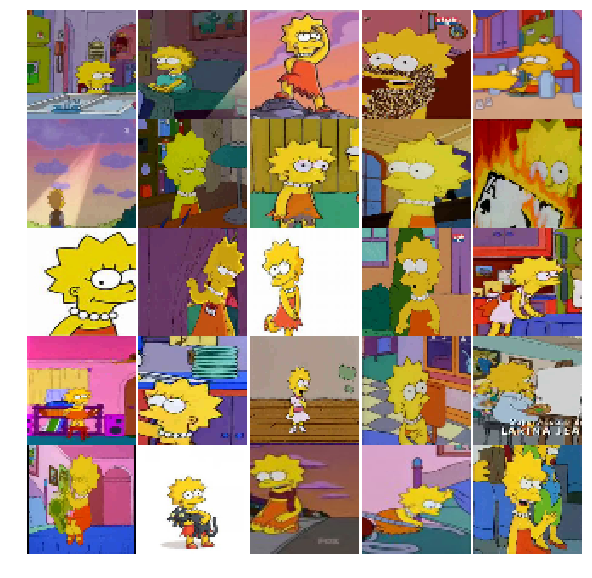

In [3]:
simpsons = glob.glob(train_path + '/lisa_simpson/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in simpsons[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (64, 64)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [4]:

dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
def load_test_set(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        #print(character_name)
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = scipy.misc.imread(dirname+'/'+image_name)
        X_test.append(scipy.misc.imresize(image,(64,64),interp='lanczos'))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)
X_test, Y_test = load_test_set(test_path, dict_characters)
# I will begin by working with the testing dataset only. Later I will load the training dataset as well.
X = X_test
y = Y_test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:1000] 
Y_train = Y_train[0:1000]
X_test = X_test[0:1000] 
Y_test = Y_test[0:1000]
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)
# Make Data 1D for compatability with standard classifiers
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 20)
Y_testHot = to_categorical(Y_test, num_classes = 20)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


('Training Data Shape:', (792, 64, 64, 3), (792, 64, 64, 3))
('Testing Data Shape:', (198, 64, 64, 3), (198, 64, 64, 3))


In [5]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# class MetricsCheckpoint(Callback):
#     """Callback that saves metrics after each epoch"""
#     def __init__(self, savepath):
#         super(MetricsCheckpoint, self).__init__()
#         self.savepath = savepath
#         self.history = {}
#     def on_epoch_end(self, epoch, logs=None):
#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
#         np.save(self.savepath, self.history)

# def plotKerasLearningCurve():
#     plt.figure(figsize=(10,5))
#     metrics = np.load('logs.npy')[()]
#     filt = ['acc'] # try to add 'loss' to see the loss learning curve
#     for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
#         l = np.array(metrics[k])
#         plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
#         x = np.argmin(l) if 'loss' in k else np.argmax(l)
#         y = l[x]
#         plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
#         plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
#     plt.legend(loc=4)
#     plt.axis([0, None, None, None]);
#     plt.grid()
#     plt.xlabel('Number of epochs')

In [6]:
img_size = 64
from os import listdir
directory_name = train_path

def load_train_set(dirname,dict_characters):
   X_train = []
   Y_train = []
   for label,character in dict_characters.items():
       list_images = os.listdir(dirname+'/'+character)
       for image_name in list_images[0:150]:
           image = scipy.misc.imread(dirname+'/'+character+'/'+image_name)
           X_train.append(scipy.misc.imresize(image,(img_size,img_size),interp='lanczos'))
           Y_train.append(label)
   return np.array(X_train), np.array(Y_train)
X_train, Y_train = load_train_set(train_path, dict_characters)       
# Normalize the data
X_train = X_train / 255.0
print("Train", X_train.shape, Y_train.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


('Train', (3000, 64, 64, 3), (3000,))


In [7]:
# Split data for cross validation
X_test, Y_test = load_test_set(test_path, dict_characters) 
X_train, Y_train = load_train_set(train_path, dict_characters)       
# Reduce Sample Size for DeBugging 
X_train = X_train[0:3000] 
Y_train = Y_train[0:3000]
X_test = X_test[0:1000] 
Y_test = Y_test[0:1000]
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 20)
Y_test = to_categorical(Y_test, num_classes = 20)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


('Training Data Shape:', (3000, 64, 64, 3), (3000, 64, 64, 3))
('Testing Data Shape:', (990, 64, 64, 3), (990, 64, 64, 3))


In [8]:
def kerasAugmentation(a,b,c,d):
    img_rows, img_cols = img_size,img_size
    input_shape = (img_rows, img_cols, 3)
    batch_size = 128
    num_classes = 20
    epochs = 16
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs)
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #3B - accuracy:', score[1])
    print('')
    y_pred = model.predict(c)
    #print("foo")
    #print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))  
kerasAugmentation(X_train, Y_train, X_test, Y_test)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/16
93/93 [==============================] - 9s 96ms/step - loss: 2.9996 - acc: 0.0437
Epoch 2/16
93/93 [==============================] - 7s 74ms/step - loss: 2.9433 - acc: 0.0974
Epoch 3/16
93/93 [==============================] - 7s 75ms/step - loss: 2.8272 - acc: 0.1286
Epoch 4/16
93/93 [==============================] - 7s 74ms/step - loss: 2.7365 - acc: 0.1415
Epoch 5/16
93/93 [==============================] - 7s 74ms/step - loss: 2.6728 - acc: 0.1613
Epoch 6/16
93/93 [==============================] - 7s 73ms/step - loss: 2.5473 - acc: 0.2127
Epoch 7/16
93/93 [==============================] - 7s 73ms/step - loss: 2.4023 - acc: 0.2661
Epoch 8/16
93/93 [==============================] - 7s 74ms/step - loss: 2.2491 - acc: 0.3181
Epoch 9/16
93/93 [===========

ResourceExhaustedError: OOM when allocating tensor with shape[9216,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/gradients/dense_1/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@dense_1/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](flatten_1/Reshape, training/SGD/gradients/activation_7/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'training/SGD/gradients/dense_1/MatMul_grad/MatMul_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2828, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-23f234c217c0>", line 57, in <module>
    kerasAugmentation(X_train, Y_train, X_test, Y_test)
  File "<ipython-input-8-23f234c217c0>", line 46, in kerasAugmentation
    steps_per_epoch=len(a) / 32, epochs=epochs)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/models.py", line 1227, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/engine/training.py", line 2016, in fit_generator
    self._make_train_function()
  File "/home/mun/.local/lib/python2.7/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/optimizers.py", line 156, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2394, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 611, in gradients
    lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 377, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 611, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py", line 973, in _MatMulGrad
    grad_b = math_ops.matmul(a, grad, transpose_a=True)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 2064, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2507, in _mat_mul
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op u'dense_1/MatMul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-8-23f234c217c0>", line 57, in <module>
    kerasAugmentation(X_train, Y_train, X_test, Y_test)
  File "<ipython-input-8-23f234c217c0>", line 27, in kerasAugmentation
    model.add(Dense(1024))
  File "/home/mun/.local/lib/python2.7/site-packages/keras/models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "/home/mun/.local/lib/python2.7/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/layers/core.py", line 843, in call
    output = K.dot(inputs, self.kernel)
  File "/home/mun/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 1057, in dot
    out = tf.matmul(x, y)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 2064, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2507, in _mat_mul
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[9216,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/gradients/dense_1/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@dense_1/MatMul"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](flatten_1/Reshape, training/SGD/gradients/activation_7/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

